In [3]:
import os, random, numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import kagglehub

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

path = kagglehub.dataset_download("mahmoudreda55/satellite-image-classification")
print("Dataset downloaded to:", path)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset downloaded to: /Users/tanishq/.cache/kagglehub/datasets/mahmoudreda55/satellite-image-classification/versions/1


In [4]:
def find_image_root(start_path):
    for root, dirs, files in os.walk(start_path):
        if dirs:
            good = 0
            for d in dirs:
                p = os.path.join(root, d)
                if os.path.isdir(p):
                    imgs = [f for f in os.listdir(p) if f.lower().endswith((".jpg",".jpeg",".png"))]
                    if len(imgs) > 5:
                        good += 1
            if good >= 2:
                return root
    return None

DATA_DIR = find_image_root(path)
print("DATA_DIR:", DATA_DIR)
assert DATA_DIR is not None, "Couldn't find class folders. Print os.walk(path) to inspect."

print("Class folders:", sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]))


DATA_DIR: /Users/tanishq/.cache/kagglehub/datasets/mahmoudreda55/satellite-image-classification/versions/1/data
Class folders: ['cloudy', 'desert', 'green_area', 'water']


In [5]:
IMG_SIZE = (150, 150)
BATCH_SIZE = 32
VAL_SPLIT = 0.2
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VAL_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=VAL_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    shuffle=True
)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)

print("Classes:", class_names)
print("NUM_CLASSES:", NUM_CLASSES)

train_ds = train_ds.cache().shuffle(1000, seed=SEED).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)


Found 5631 files belonging to 4 classes.
Using 4505 files for training.
Found 5631 files belonging to 4 classes.
Using 1126 files for validation.
Classes: ['cloudy', 'desert', 'green_area', 'water']
NUM_CLASSES: 4


In [6]:
def count_images_per_class(data_dir):
    counts = {}
    for c in sorted(os.listdir(data_dir)):
        p = os.path.join(data_dir, c)
        if os.path.isdir(p):
            counts[c] = len([f for f in os.listdir(p) if f.lower().endswith((".jpg",".jpeg",".png"))])
    return counts

counts = count_images_per_class(DATA_DIR)
counts


{'cloudy': 1500, 'desert': 1131, 'green_area': 1500, 'water': 1500}

In [7]:
val_counts = np.zeros(NUM_CLASSES, dtype=int)

for x, y in val_ds:
    val_counts += np.sum(y.numpy(), axis=0).astype(int)

print("Validation distribution:")
for i, c in enumerate(val_counts):
    print(f"{class_names[i]}: {c}")


Validation distribution:
cloudy: 267
desert: 224
green_area: 318
water: 317


2026-02-18 16:59:39.329877: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2026-02-18 16:59:39.712205: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


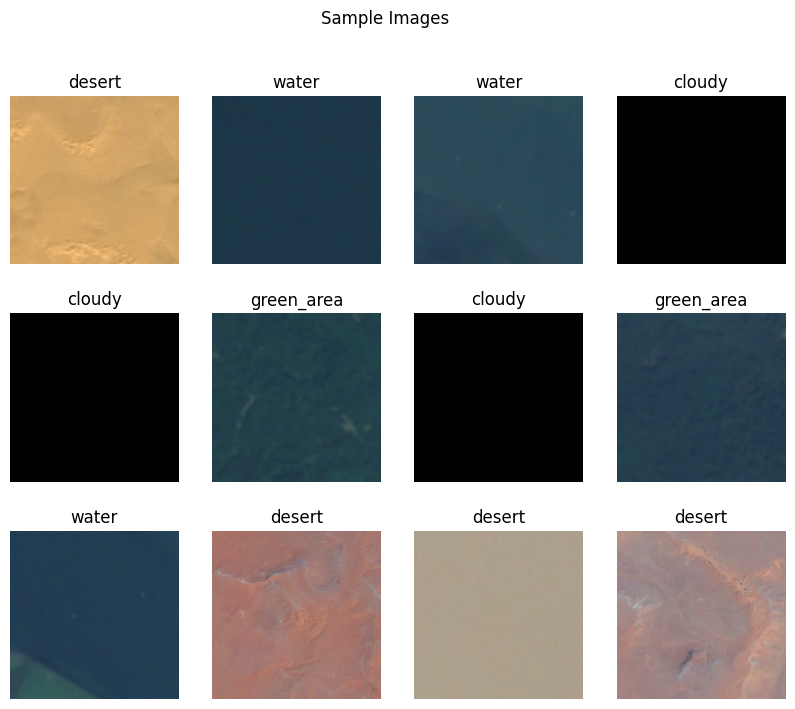

Batch shape: (32, 150, 150, 3) (32, 4)
Pixel range: 0.0 230.31598


In [8]:
plt.figure(figsize=(10, 8))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i].numpy())])
        plt.axis("off")
plt.suptitle("Sample Images")
plt.show()

for images, labels in train_ds.take(1):
    print("Batch shape:", images.shape, labels.shape)
    print("Pixel range:", tf.reduce_min(images).numpy(), tf.reduce_max(images).numpy())


In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_training(history, title="Training Curves"):
    h = history.history
    epochs = range(1, len(h["loss"]) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, h["accuracy"], label="Train")
    plt.plot(epochs, h["val_accuracy"], label="Val")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.legend(); plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, h["loss"], label="Train")
    plt.plot(epochs, h["val_loss"], label="Val")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.legend(); plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def get_y_true_pred(model, ds):
    y_true, y_pred = [], []
    for x, y in ds:
        p = model.predict(x, verbose=0)
        y_true.extend(np.argmax(y.numpy(), axis=1))
        y_pred.extend(np.argmax(p, axis=1))
    return np.array(y_true), np.array(y_pred)

def plot_confusion_matrix(cm, classes, title="Confusion Matrix"):
    plt.figure(figsize=(7, 6))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45, ha="right")
    plt.yticks(ticks, classes)

    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 ha="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    10,617,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,711,364 (40.86 MB)

 Trainable params: 10,711,364 (40.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 63s 444ms/step - accuracy: 0.8104 - loss: 0.3701 - val_accuracy: 0.8597 - val_loss: 0.2505
Epoch 2/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 55s 384ms/step - accuracy: 0.9019 - loss: 0.2199 - val_accuracy: 0.8979 - val_loss: 0.2204
Epoch 3/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 25s 180ms/step - accuracy: 0.9154 - loss: 0.1819 - val_accuracy: 0.9192 - val_loss: 0.1740
Epoch 4/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 27s 189ms/step - accuracy: 0.9239 - loss: 0.1638 - val_accuracy: 0.9005 - val_loss: 0.2121
Epoch 5/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 34s 239ms/step - accuracy: 0.9285 - loss: 0.1537 - val_accuracy: 0.9290 - val_loss: 0.1552
Epoch 6/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 54s 383ms/step - accuracy: 0.9396 - loss: 0.1379 - val_accuracy: 0.9281 - val_loss: 0.1607
Epoch 7/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 51s 364ms/step - accuracy: 0.9450 - loss: 0.1306 - val_accuracy: 0.8801 - val_loss: 0.2188
Epoch 8/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 47s 330ms/step - accuracy: 0.9341 - loss: 0

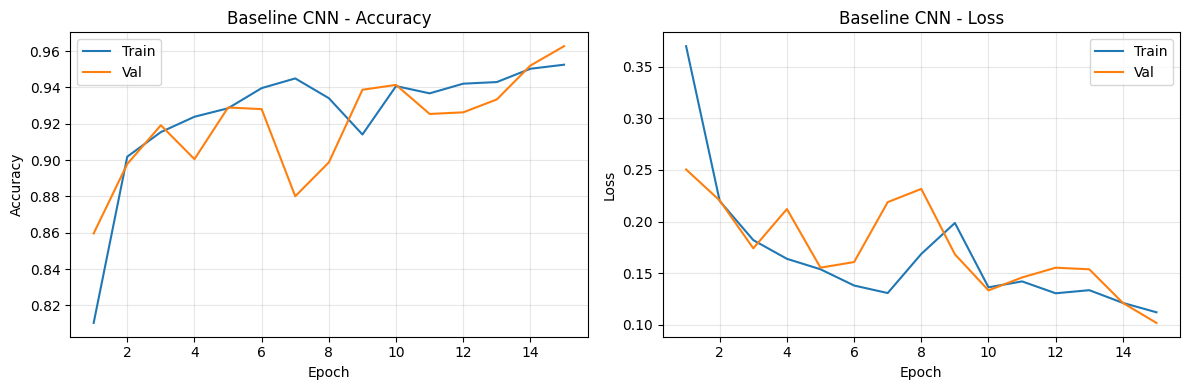

In [10]:
baseline_model = keras.Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),
    layers.Rescaling(1./255),

    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

baseline_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

baseline_model.summary()

history_baseline = baseline_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15
)

plot_training(history_baseline, "Baseline CNN")


BASELINE REPORT (VAL):
              precision    recall  f1-score   support

      cloudy     1.0000    1.0000    1.0000       267
      desert     0.9956    1.0000    0.9978       224
  green_area     0.9482    0.9214    0.9346       318
       water     0.9231    0.9464    0.9346       317

    accuracy                         0.9627      1126
   macro avg     0.9667    0.9669    0.9667      1126
weighted avg     0.9628    0.9627    0.9627      1126



2026-02-18 17:10:49.332217: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


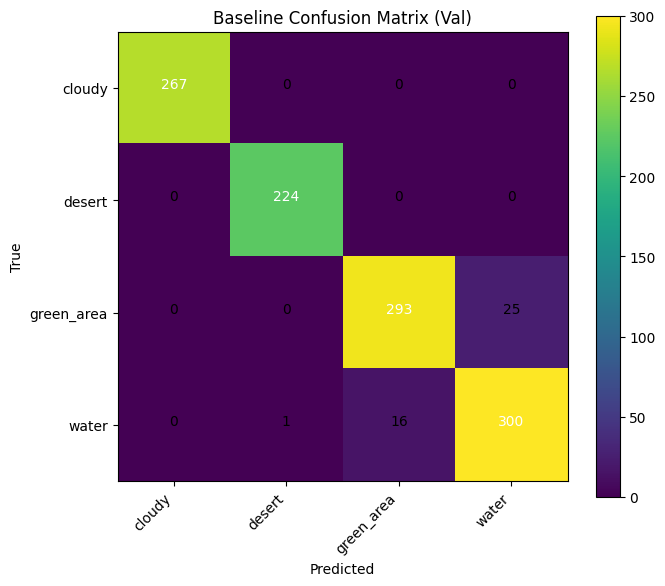

In [11]:
y_true_b, y_pred_b = get_y_true_pred(baseline_model, val_ds)

print("BASELINE REPORT (VAL):")
print(classification_report(
    y_true_b, y_pred_b,
    labels=list(range(NUM_CLASSES)),
    target_names=class_names,
    digits=4,
    zero_division=0
))

cm_b = confusion_matrix(y_true_b, y_pred_b, labels=list(range(NUM_CLASSES)))
plot_confusion_matrix(cm_b, class_names, "Baseline Confusion Matrix (Val)")


Epoch 1/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 67s 469ms/step - accuracy: 0.8559 - loss: 2.9013 - val_accuracy: 0.3233 - val_loss: 25.0484 - learning_rate: 0.0010
Epoch 2/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 75s 530ms/step - accuracy: 0.9032 - loss: 0.5749 - val_accuracy: 0.2913 - val_loss: 25.2556 - learning_rate: 0.0010
Epoch 3/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 78s 557ms/step - accuracy: 0.8957 - loss: 0.5725 - val_accuracy: 0.7167 - val_loss: 0.4330 - learning_rate: 0.0010
Epoch 4/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 76s 540ms/step - accuracy: 0.9012 - loss: 0.5202 - val_accuracy: 0.9130 - val_loss: 0.2473 - learning_rate: 0.0010
Epoch 5/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 76s 539ms/step - accuracy: 0.8937 - loss: 0.7646 - val_accuracy: 0.7709 - val_loss: 0.6321 - learning_rate: 0.0010
Epoch 6/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 69s 492ms/step - accuracy: 0.9165 - loss: 0.2150 - val_accuracy: 0.7948 - val_loss: 0.8568 - learning_rate: 0.0010
Epoch 7/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 83s 587ms/step - accuracy: 0

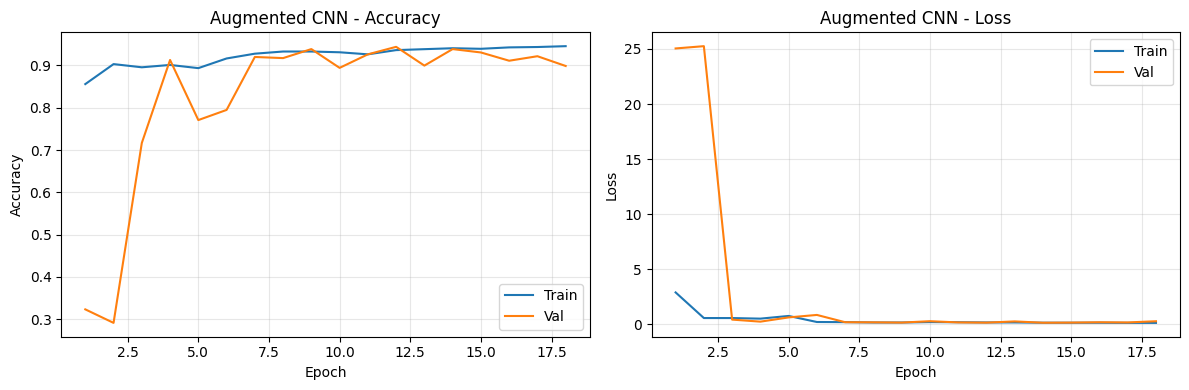

In [12]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.10),
    layers.RandomZoom(0.10),
    layers.RandomContrast(0.10),
], name="augmentation")

aug_model = keras.Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),
    data_augmentation,
    layers.Rescaling(1./255),

    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dropout(0.4),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

aug_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2)
]

history_aug = aug_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=callbacks
)

plot_training(history_aug, "Augmented CNN")


AUGMENTED REPORT (VAL):
              precision    recall  f1-score   support

      cloudy     1.0000    1.0000    1.0000       267
      desert     0.9912    1.0000    0.9956       224
  green_area     0.8659    0.9340    0.8986       318
       water     0.9276    0.8486    0.8863       317

    accuracy                         0.9387      1126
   macro avg     0.9462    0.9456    0.9451      1126
weighted avg     0.9400    0.9387    0.9385      1126



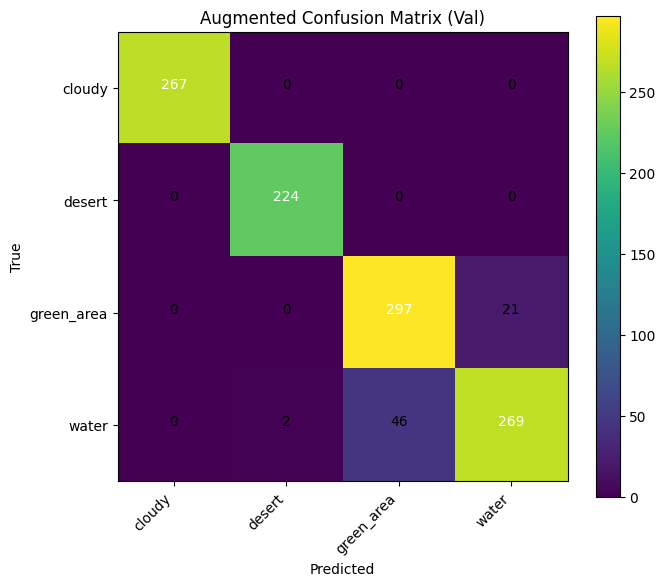

In [13]:
y_true_a, y_pred_a = get_y_true_pred(aug_model, val_ds)

print("AUGMENTED REPORT (VAL):")
print(classification_report(
    y_true_a, y_pred_a,
    labels=list(range(NUM_CLASSES)),
    target_names=class_names,
    digits=4,
    zero_division=0
))

cm_a = confusion_matrix(y_true_a, y_pred_a, labels=list(range(NUM_CLASSES)))
plot_confusion_matrix(cm_a, class_names, "Augmented Confusion Matrix (Val)")


In [14]:
import pandas as pd

def last_metrics(history):
    h = history.history
    return h["accuracy"][-1], h["val_accuracy"][-1], h["loss"][-1], h["val_loss"][-1]

b_tr_acc, b_va_acc, b_tr_loss, b_va_loss = last_metrics(history_baseline)
a_tr_acc, a_va_acc, a_tr_loss, a_va_loss = last_metrics(history_aug)

df_compare = pd.DataFrame([
    {"Model":"Baseline", "Train Acc":b_tr_acc, "Val Acc":b_va_acc, "Train-Val Gap":(b_tr_acc-b_va_acc)},
    {"Model":"Augmented", "Train Acc":a_tr_acc, "Val Acc":a_va_acc, "Train-Val Gap":(a_tr_acc-a_va_acc)},
])

df_compare


,Model,Train Acc,Val Acc,Train-Val Gap
0,Baseline,0.952497,0.962700,-0.010203
1,Augmented,0.945616,0.898757,0.046859


Misclassified: 69


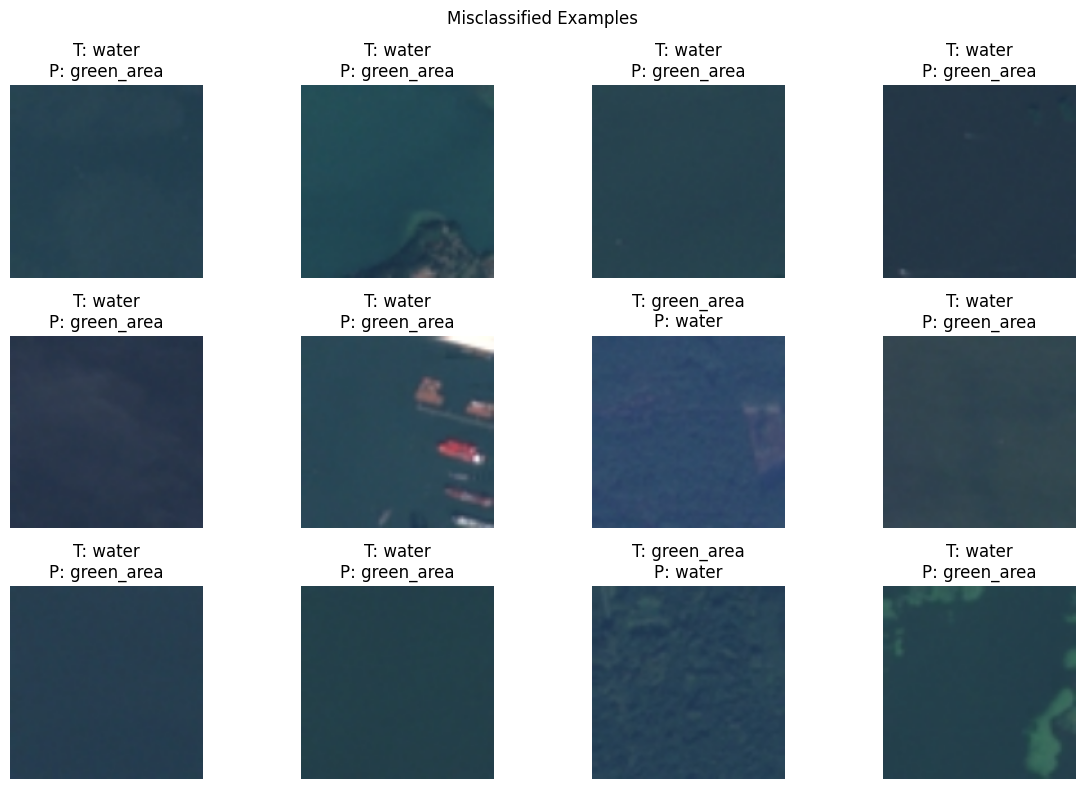

In [15]:
def show_misclassified(model, ds, max_images=12):
    y_true, y_pred = get_y_true_pred(model, ds)
    wrong = np.where(y_true != y_pred)[0]
    print("Misclassified:", len(wrong))
    if len(wrong) == 0:
        return

    imgs_all = []
    for x, y in ds:
        imgs_all.append(x.numpy())
    imgs_all = np.concatenate(imgs_all, axis=0)

    pick = wrong[:max_images]
    plt.figure(figsize=(12, 8))
    for i, idx in enumerate(pick):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(imgs_all[idx].astype("uint8"))
        plt.title(f"T: {class_names[y_true[idx]]}\nP: {class_names[y_pred[idx]]}")
        plt.axis("off")
    plt.suptitle("Misclassified Examples")
    plt.tight_layout()
    plt.show()

show_misclassified(aug_model, val_ds, 12)


2026-02-18 17:30:52.681738: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


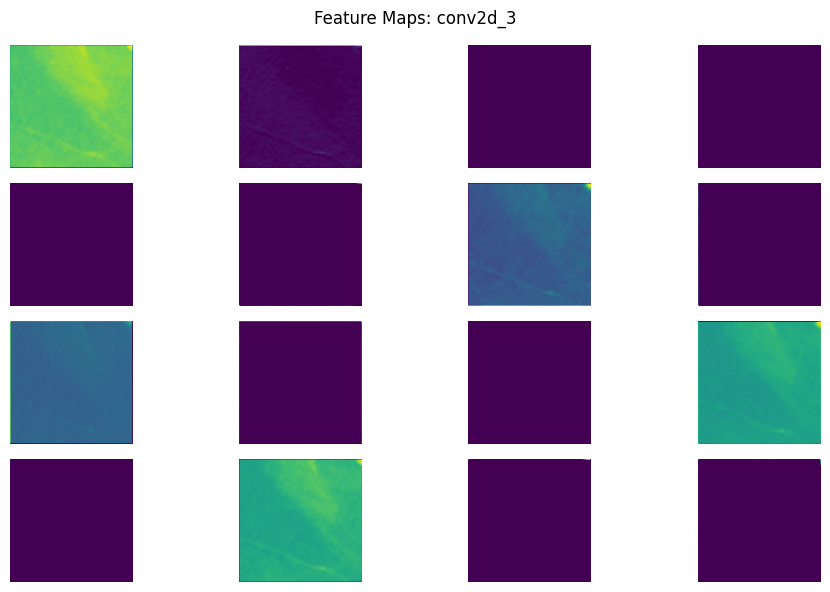

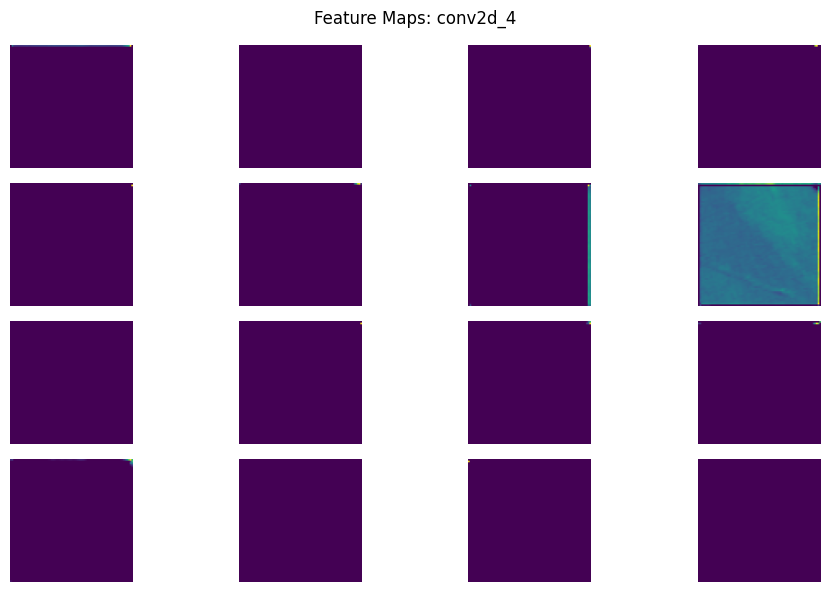

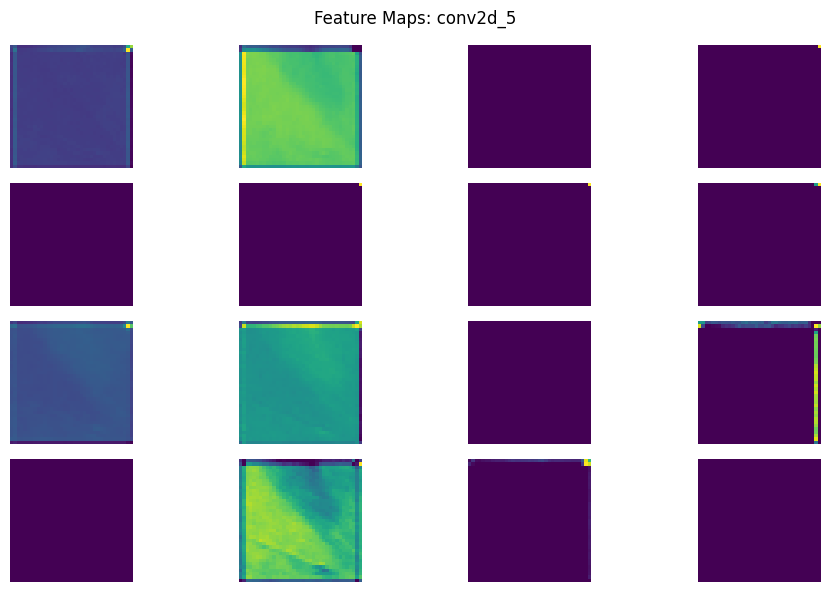

In [16]:
conv_outputs, conv_names = [], []

inp = keras.Input(shape=(*IMG_SIZE, 3))
x = inp
for layer in aug_model.layers:
    x = layer(x)
    if isinstance(layer, layers.Conv2D):
        conv_outputs.append(x)
        conv_names.append(layer.name)

feature_model = keras.Model(inputs=inp, outputs=conv_outputs)

for images, labels in val_ds.take(1):
    sample = images[0:1]

feature_maps = feature_model.predict(sample, verbose=0)

for layer_idx in range(min(3, len(feature_maps))):
    fmap = feature_maps[layer_idx][0]
    n = min(16, fmap.shape[-1])

    plt.figure(figsize=(10, 6))
    for i in range(n):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(fmap[:, :, i])
        plt.axis("off")
    plt.suptitle(f"Feature Maps: {conv_names[layer_idx]}")
    plt.tight_layout()
    plt.show()


Epoch 1/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 56s 395ms/step - accuracy: 0.8943 - loss: 0.2453 - val_accuracy: 0.2815 - val_loss: 1.6270 - learning_rate: 0.0010
Epoch 2/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 59s 422ms/step - accuracy: 0.9170 - loss: 0.1805 - val_accuracy: 0.3277 - val_loss: 1.4325 - learning_rate: 0.0010
Epoch 3/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 63s 448ms/step - accuracy: 0.9314 - loss: 0.1557 - val_accuracy: 0.7691 - val_loss: 0.5318 - learning_rate: 5.0000e-04
Epoch 4/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 54s 380ms/step - accuracy: 0.9363 - loss: 0.1476 - val_accuracy: 0.7194 - val_loss: 0.5207 - learning_rate: 5.0000e-04


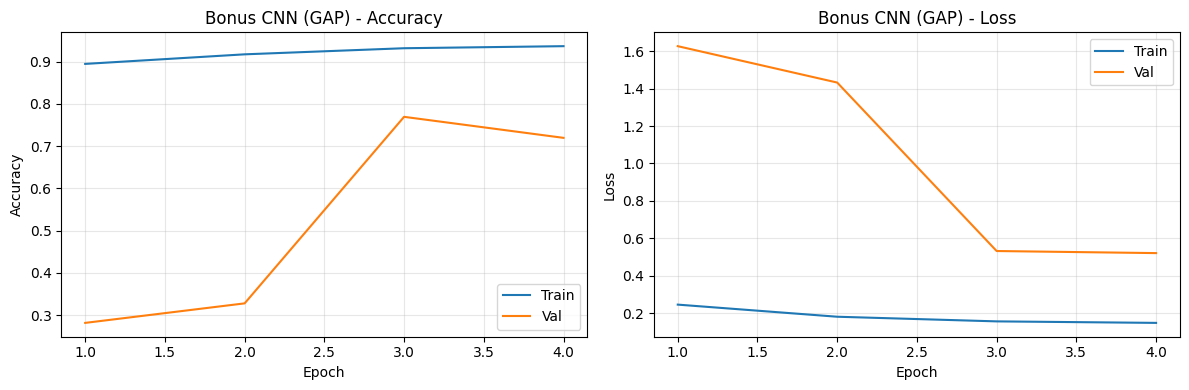

In [17]:
gap_model = keras.Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),
    data_augmentation,
    layers.Rescaling(1./255),

    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(128, activation="relu"),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

gap_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history_gap = gap_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=callbacks
)

plot_training(history_gap, "Bonus CNN (GAP)")


In [18]:
y_true_g, y_pred_g = get_y_true_pred(gap_model, val_ds)

print("BONUS GAP REPORT (VAL):")
print(classification_report(
    y_true_g, y_pred_g,
    labels=list(range(NUM_CLASSES)),
    target_names=class_names,
    digits=4,
    zero_division=0
))

g_tr_acc, g_va_acc, g_tr_loss, g_va_loss = last_metrics(history_gap)

df_compare2 = pd.concat([
    df_compare,
    pd.DataFrame([{"Model":"Bonus (GAP)", "Train Acc":g_tr_acc, "Val Acc":g_va_acc, "Train-Val Gap":(g_tr_acc-g_va_acc)}])
], ignore_index=True)

df_compare2


BONUS GAP REPORT (VAL):
              precision    recall  f1-score   support

      cloudy     0.0000    0.0000    0.0000       267
      desert     0.0000    0.0000    0.0000       224
  green_area     0.0000    0.0000    0.0000       318
       water     0.2815    1.0000    0.4394       317

    accuracy                         0.2815      1126
   macro avg     0.0704    0.2500    0.1098      1126
weighted avg     0.0793    0.2815    0.1237      1126



,Model,Train Acc,Val Acc,Train-Val Gap
0,Baseline,0.952497,0.962700,-0.010203
1,Augmented,0.945616,0.898757,0.046859
2,Bonus (GAP),0.936293,0.719361,0.216932


In [19]:
def show_predictions_analysis(model, ds, max_images=6):
    y_true, y_pred = get_y_true_pred(model, ds)

    correct_idx = np.where(y_true == y_pred)[0]
    wrong_idx   = np.where(y_true != y_pred)[0]

    print("Total samples:", len(y_true))
    print("Correct predictions:", len(correct_idx))
    print("Incorrect predictions:", len(wrong_idx))
    print("Accuracy:", len(correct_idx) / len(y_true))

    # Collect images in dataset order
    imgs_all = []
    for x, y in ds:
        imgs_all.append(x.numpy())
    imgs_all = np.concatenate(imgs_all, axis=0)

    # ---------------------------
    # SHOW CORRECT PREDICTIONS
    # ---------------------------
    if len(correct_idx) > 0:
        pick_correct = correct_idx[:max_images]

        plt.figure(figsize=(12, 6))
        for i, idx in enumerate(pick_correct):
            ax = plt.subplot(2, max_images//2, i+1)
            plt.imshow(imgs_all[idx].astype("uint8"))
            plt.title(f"Correct\n{class_names[y_true[idx]]}")
            plt.axis("off")
        plt.suptitle("Correct Predictions")
        plt.tight_layout()
        plt.show()

    # ---------------------------
    # SHOW MISCLASSIFIED
    # ---------------------------
    if len(wrong_idx) > 0:
        pick_wrong = wrong_idx[:max_images]

        plt.figure(figsize=(12, 6))
        for i, idx in enumerate(pick_wrong):
            ax = plt.subplot(2, max_images//2, i+1)
            plt.imshow(imgs_all[idx].astype("uint8"))
            plt.title(f"T: {class_names[y_true[idx]]}\nP: {class_names[y_pred[idx]]}")
            plt.axis("off")
        plt.suptitle("Misclassified Examples")
        plt.tight_layout()
        plt.show()


Total samples: 1126
Correct predictions: 1057
Incorrect predictions: 69
Accuracy: 0.9387211367673179


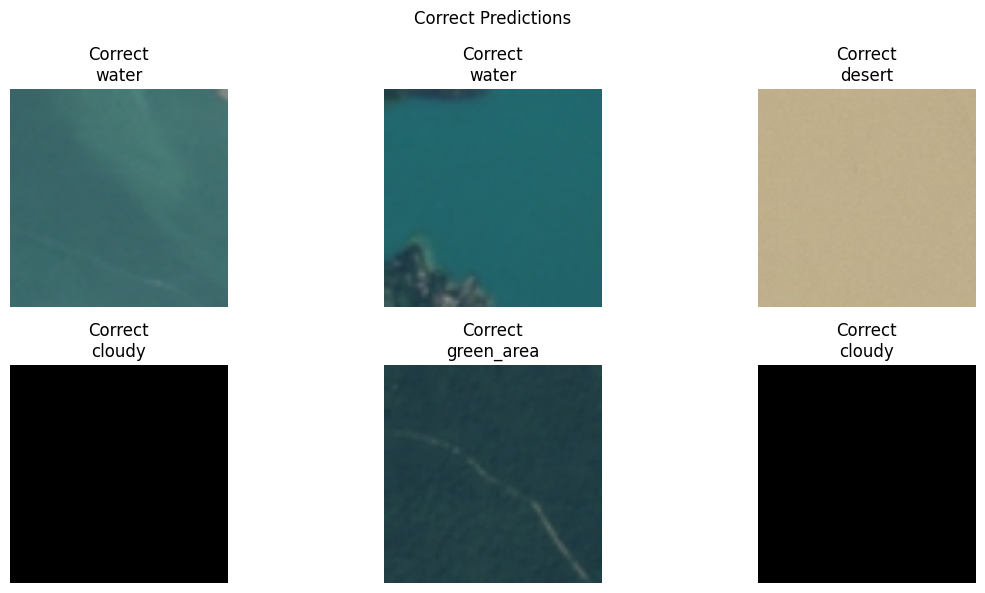

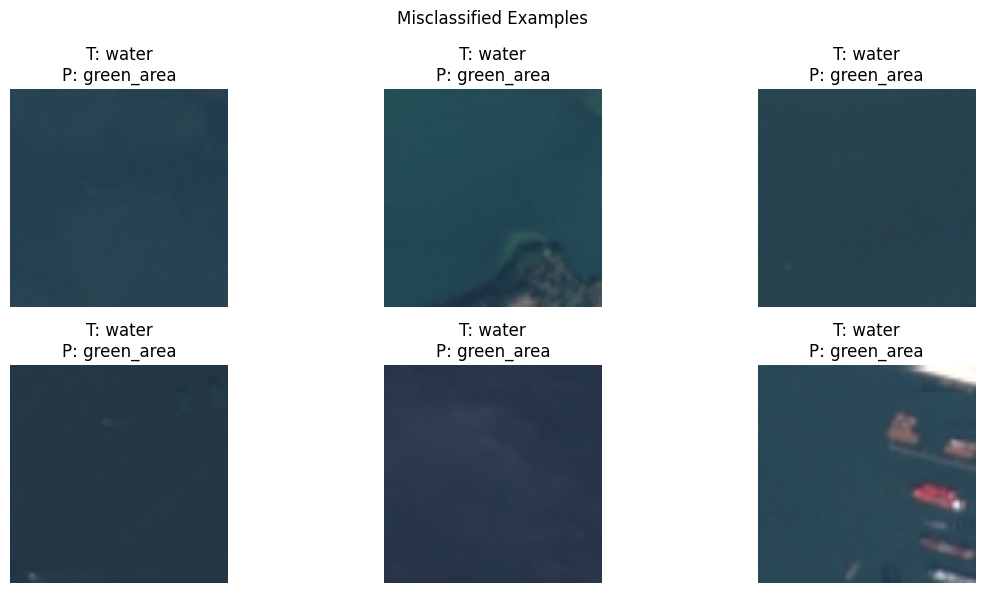

In [20]:
show_predictions_analysis(aug_model, val_ds, max_images=6)
